State: (0, 0), Action: RIGHT, Next: (1, 0), Reward: -1
State: (1, 0), Action: RIGHT, Next: (1, 1), Reward: -1
State: (1, 1), Action: RIGHT, Next: (1, 2), Reward: -1
State: (1, 2), Action: RIGHT, Next: (1, 3), Reward: -1
State: (1, 3), Action: DOWN, Next: (1, 2), Reward: -1
State: (1, 2), Action: RIGHT, Next: (2, 2), Reward: -1
State: (2, 2), Action: RIGHT, Next: (2, 2), Reward: -10
State: (2, 2), Action: DOWN, Next: (3, 2), Reward: -1
State: (3, 2), Action: RIGHT, Next: (3, 3), Reward: -1
State: (3, 3), Action: RIGHT, Next: (4, 3), Reward: -1
State: (4, 3), Action: RIGHT, Next: (4, 3), Reward: -10
State: (4, 3), Action: UP, Next: (3, 3), Reward: -1
State: (3, 3), Action: RIGHT, Next: (3, 3), Reward: -10
State: (3, 3), Action: LEFT, Next: (3, 2), Reward: -1
State: (3, 2), Action: UP, Next: (2, 2), Reward: -1
State: (2, 2), Action: UP, Next: (1, 2), Reward: -1
State: (1, 2), Action: RIGHT, Next: (0, 2), Reward: -1
State: (0, 2), Action: RIGHT, Next: (0, 3), Reward: -1
State: (0, 3), Acti

/var/folders/j4/2nwxqq795dq2735xfprfpxkm0000gn/T/ipykernel_89648/2225738402.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdGy', 5)


Video saved as: maze_navigation.mp4


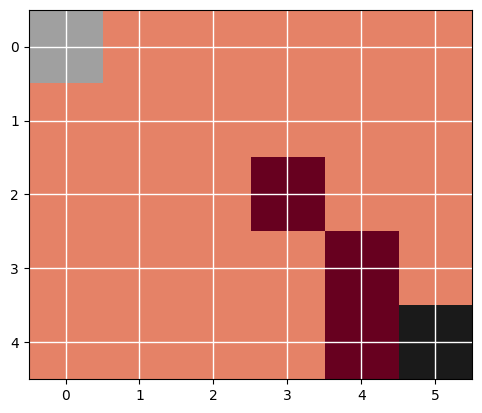

In [6]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter

ROWS, COLS = 5, 6
START_STATE = (0, 0)
GOAL_STATE = (4, 5)
TRUE_OBSTACLES = {(0, 1), (2, 1), (2, 3), (3, 1), (3, 4), (4, 4)}
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
ACTION_PROBS = {
    'UP': {'UP': 0.8, 'LEFT': 0.1, 'RIGHT': 0.1},
    'DOWN': {'DOWN': 0.8, 'LEFT': 0.1, 'RIGHT': 0.1},
    'LEFT': {'LEFT': 0.8, 'UP': 0.1, 'DOWN': 0.1},
    'RIGHT': {'RIGHT': 0.8, 'UP': 0.1, 'DOWN': 0.1},
}

known_obstacles = set()
frames = []  # For storing maze frames


def is_out_of_bounds(state):
    r, c = state
    return r < 0 or r >= ROWS or c < 0 or c >= COLS

def is_real_obstacle(state):
    return state in TRUE_OBSTACLES

def get_next_state(state, action):
    r, c = state
    if action == 'UP': return (r - 1, c)
    if action == 'DOWN': return (r + 1, c)
    if action == 'LEFT': return (r, c - 1)
    if action == 'RIGHT': return (r, c + 1)

def get_all_states():
    return [(r, c) for r in range(ROWS) for c in range(COLS) if (r, c) not in known_obstacles]

def value_iteration(states, gamma=0.9, epsilon=0.1):
    V = {s: 0 for s in states}
    while True:
        delta = 0
        new_V = V.copy()
        for state in states:
            if state == GOAL_STATE:
                new_V[state] = 0
                continue
            max_utility = float('-inf')
            for action in ACTIONS:
                expected_utility = 0
                for a_prime, prob in ACTION_PROBS[action].items():
                    next_state = get_next_state(state, a_prime)
                    if is_out_of_bounds(next_state) or next_state in known_obstacles:
                        reward = -10
                        next_state = state
                    elif next_state == GOAL_STATE:
                        reward = 100
                    else:
                        reward = -1
                    expected_utility += prob * (reward + gamma * V.get(next_state, 0))
                max_utility = max(max_utility, expected_utility)
            new_V[state] = max_utility
            delta = max(delta, abs(new_V[state] - V[state]))
        V = new_V
        if delta < epsilon:
            break
    return V

def extract_policy(V, states):
    policy = {}
    for state in states:
        if state == GOAL_STATE:
            policy[state] = None
            continue
        best_action = None
        best_value = float('-inf')
        for action in ACTIONS:
            expected_utility = 0
            for a_prime, prob in ACTION_PROBS[action].items():
                next_state = get_next_state(state, a_prime)
                if is_out_of_bounds(next_state) or next_state in known_obstacles:
                    reward = -10
                    next_state = state
                elif next_state == GOAL_STATE:
                    reward = 100
                else:
                    reward = -1
                expected_utility += prob * (reward + V.get(next_state, 0))
            if expected_utility > best_value:
                best_value = expected_utility
                best_action = action
        policy[state] = best_action
    return policy

def simulate_move(state, action):
    prob_dist = ACTION_PROBS[action]
    rand = random.random()
    cumulative = 0.0
    for a_prime, prob in prob_dist.items():
        cumulative += prob
        if rand < cumulative:
            intended_state = get_next_state(state, a_prime)
            break
    if is_out_of_bounds(intended_state) or is_real_obstacle(intended_state):
        known_obstacles.add(intended_state)
        return state, -10
    return intended_state, 100 if intended_state == GOAL_STATE else -1

def draw_maze(agent_pos):
    maze = np.zeros((ROWS, COLS))
    for r in range(ROWS):
        for c in range(COLS):
            if (r, c) in known_obstacles:
                maze[r, c] = -1
    maze[START_STATE[0], START_STATE[1]] = 2
    maze[GOAL_STATE[0], GOAL_STATE[1]] = 3
    if agent_pos != START_STATE and agent_pos != GOAL_STATE:
        maze[agent_pos[0], agent_pos[1]] = 1
    frames.append(maze.copy())

def create_animation(filename="maze_navigation.mp4", interval=1000):
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('RdGy', 5)
    cmap.set_under('darkred')
    cmap.set_over('darkgreen')
    cmap.set_bad('black')

    im = ax.imshow(frames[0], cmap=cmap, interpolation='nearest', vmin=-1, vmax=3)
    plt.xticks(np.arange(0, COLS, 1))
    plt.yticks(np.arange(0, ROWS, 1))
    plt.grid(which='both', color='white', linestyle='-', linewidth=1)

    def update(frame):
        im.set_data(frame)
        return [im]

    ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
    ani.save(filename, writer='ffmpeg')
    print(f"Video saved as: {filename}")

# ---------------------------------------------
# Main Execution
# ---------------------------------------------

def main():
    current_state = START_STATE
    path = [current_state]
    draw_maze(current_state)

    while current_state != GOAL_STATE:
        states = get_all_states()
        V = value_iteration(states)
        policy = extract_policy(V, states)
        action = policy.get(current_state)
        if action is None:
            print("No available action from", current_state)
            break
        next_state, reward = simulate_move(current_state, action)
        print(f"State: {current_state}, Action: {action}, Next: {next_state}, Reward: {reward}")
        draw_maze(next_state)
        path.append(next_state)
        current_state = next_state

    print("\nFinal Path to Goal:")
    print(path)
    create_animation()

if __name__ == "__main__":
    main()
